GFHAH (2012)
- 44 participants, 60 problems per participant

In [1]:
from chase.base import *
from chase.utils import *
from chase.fit import *
import seaborn as sns
from cogmod import cpt
from chase.cpt import value_fnc


FIGDEST = 'figures/'

def gw(p, delta, gamma):
    a = delta * np.power(p, gamma)
    b = np.power(1-p, gamma)
    return a / (a + b)

def problem_array(row):
    return np.array([[row[['g1o1', 'g1p1']].values, row[['g1o2', 'g1p2']].values],
                     [row[['g2o1', 'g2p1']].values, row[['g2o2', 'g2p2']].values]])

COMPARISON_RESULTS = {}

def model_table(sid, force=False):
    if sid not in COMPARISON_RESULTS or force:
        COMPARISON_RESULTS[sid] = pd.read_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid, index_col=0)
    return COMPARISON_RESULTS[sid]


def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

In [3]:
data = pd.read_csv('data/glockner2016/Glockner2016_EB_all.csv')

In [8]:
data.exp.unique()

array([1, 2, 3, 4, 5])

In [ ]:
data = data[(data.description==0) & (data.exp==3)]
probdf = data[['g1o1', 'g1p1', 'g1o2', 'g1p2', 'g2o1', 'g2p1', 'g2o2', 'g2p2']].drop_duplicates().reset_index()

for i, row in probdf.iterrows():
    p = problem_array(row)
    evA = expected_value(p[0])
    evB = expected_value(p[1])
    if evA > evB:
        problems[i] = np.array([p[1], p[0]])
    else:
        problems[i] = p


# GFHAH (2012)

In [5]:
data_exp1 = data[(data.description==0) & (data.exp==1)]
data_exp1.loc[:,'problem'] = np.nan
data_exp1.rename(columns={'subj': 'subject', 'dec': 'choice', 'samples': 'samplesize'}, inplace=True)
data_exp1['choice'] = data_exp1['choice'] - 1
data_exp1['group'] = 0

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
problems = {}

p = []
for i, row in data_exp1.iterrows():
    a = problem_array(row)
    problems[i] = a
    p.append(i)
data_exp1.loc[:,'problem'] = p

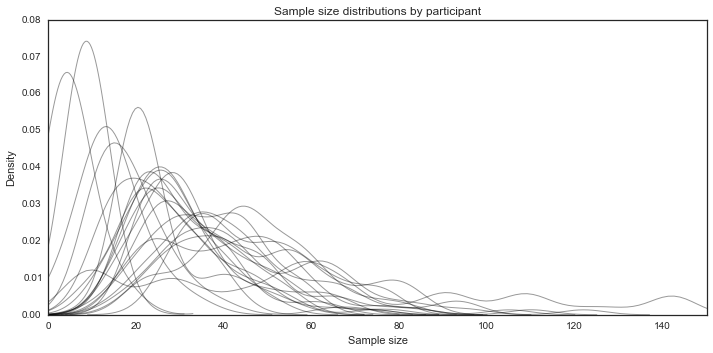

In [102]:
fig, axi = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

ax = axi
for i, grp in data_exp1.groupby('subject'):
    sns.kdeplot(grp.samplesize, bw=5, color='black', alpha=.4, ax=ax, linewidth=1)
ax.legend([])
ax.set_title('Sample size distributions by participant')
ax.set_xlim(0, 150)
ax.set_xlabel('Sample size')
ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

fig.savefig(FIGDEST+'glockner_samplesize_by_participant.pdf', bbox_inches='tight')

## Optional stopping

In [8]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 10],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'prelec_gamma_loss': [0, 5, 1.],
        'prelec_elevation_loss': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'mu': [0., np.inf, 40.],
        'sc': [0., np.inf, 1.],

}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,}

N_ITER = 1
SIM_ID = 'glockner2016'
OUTDIR = 'chase_fitresults_glockner2016'

# a list of different parameter combinations that will
# be fit
PARSETS = [['theta', 'p_stay', 'tau'],
           ['theta', 'p_stay', 'tau', 'prelec_gamma'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'pow_gain'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'pow_gain', 'w_loss'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'pow_gain', 'lambda'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'lambda'],
           ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation', 'pow_gain'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation', 'pow_gain', 'w_loss'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation', 'lambda'],
           ['theta', 'p_stay', 'tau', 'pow_gain'],
           #['theta', 'p_stay', 'tau', 'pow_gain', 'lambda'],
           #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
           #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss', 'lambda'],
           ]

In [71]:
for sid in data_exp1.subject.unique()[10:]:
    
    SIM_ID = 'glockner2016_individual_subj=%s' % sid

    for parset in PARSETS:

        fitting = {p: PARS[p] for p in parset}

        # initialize the model
        m = CHASEModel(drift='cpt',
                       startdist='laplace',
                       problems=problems)

        # fit
        results = fit_mlh(m, problems, data_exp1[data_exp1.subject==sid], 
                          SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

        print results.sort('nllh')

glockner2016_individual_subj=1033(p_stay,tau,theta|c=0.5)
0/10
['theta']: [ 1.]
iteration            0
success           True
nllh          285.5242
k                    3
N                   58
bic           583.2297
theta                1
p_stay       0.9638854
tau          0.2744538
Name: 0, dtype: object
glockner2016_individual_subj=1033(p_stay,tau,theta|c=0.5)
1/10
['theta']: [ 2.]
iteration               0
success              True
nllh             274.0951
k                       3
N                      58
bic              560.3715
theta                   2
p_stay          0.8770595
tau          3.328925e-06
Name: 1, dtype: object
glockner2016_individual_subj=1033(p_stay,tau,theta|c=0.5)
2/10
['theta']: [ 3.]
iteration               0
success              True
nllh             272.9841
k                       3
N                      58
bic              558.1496
theta                   3
p_stay          0.7601972
tau          8.861956e-07
Name: 2, dtype: object
glockner2016_ind

In [171]:
for sid in data_exp1.subject.unique():

    results = pd.DataFrame([], columns=['sim_id', 'stoprule', 'weighting', 'switching',
                                        'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                        'theta', 'p_stop', 'mu', 'sc', 
                                        'prelec_gamma', 'prelec_elevation',
                                        'pow_gain', 'w_loss'])

    for i, parset in enumerate(PARSETS):
        model_id = 'glockner2016_individual_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'optional'
        results.loc[results.shape[0]-1,'switching'] = False

    results.to_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid)

In [172]:
arr = []
for sid in data_exp1.subject.unique():
    arr.append(model_table(sid, force=True))
compdf = pd.concat(arr)

In [173]:
compdf.head()

,sim_id,stoprule,weighting,switching,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss
0,"glockner2016_individual_subj=1003(p_stay,tau,t...",optional,NaN,0.0,3,59,288.100155,588.432923,0.894099,9.409882e-07,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"glockner2016_individual_subj=1003(p_stay,prele...",optional,NaN,False,4,59,277.431185,571.172520,0.794634,2.193532e-10,3,NaN,NaN,NaN,0.273763,NaN,NaN,NaN
2,"glockner2016_individual_subj=1003(p_stay,pow_g...",optional,NaN,False,6,59,272.538268,569.541760,0.700706,3.320526e-02,4,NaN,NaN,NaN,0.329402,1.029513,0.000018,NaN
0,"glockner2016_individual_subj=1006(p_stay,tau,t...",optional,NaN,0.0,3,59,302.815387,617.863386,0.843994,1.245516e-05,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"glockner2016_individual_subj=1006(p_stay,prele...",optional,NaN,False,4,59,290.428074,597.166297,0.758228,1.440015e-07,4,NaN,NaN,NaN,0.257286,NaN,NaN,NaN


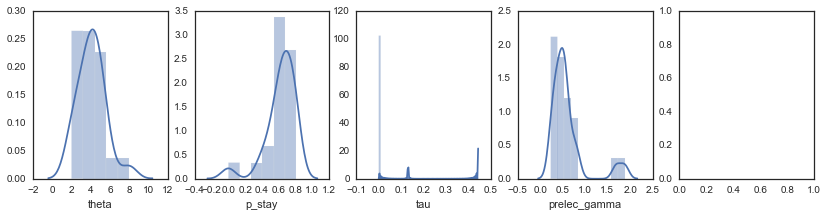

In [134]:
fig, ax = plt.subplots(1, 5, figsize=(14,3))
sns.distplot(compdf['theta'], ax=ax[0])
sns.distplot(compdf['p_stay'], ax=ax[1])
sns.distplot(compdf['tau'], ax=ax[2])
sns.distplot(compdf['prelec_gamma'], ax=ax[3])

In [163]:
p2 = compdf[~np.isnan(compdf.prelec_elevation)]

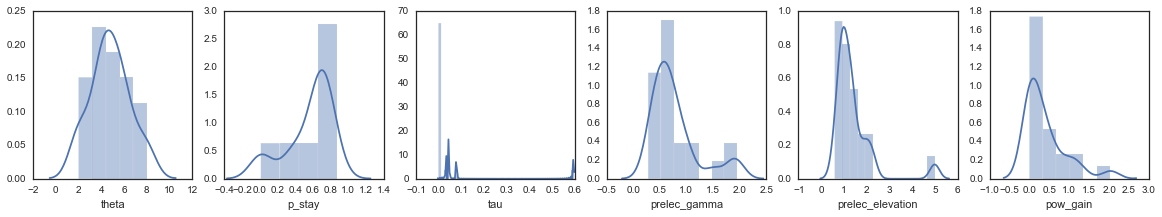

In [167]:
fig, ax = plt.subplots(1, 6, figsize=(20,3))
sns.distplot(p2['theta'], ax=ax[0])
sns.distplot(p2['p_stay'], ax=ax[1])
sns.distplot(p2['tau'], ax=ax[2])
sns.distplot(p2['prelec_gamma'], ax=ax[3])
sns.distplot(p2['prelec_elevation'], ax=ax[4])
sns.distplot(p2['pow_gain'], ax=ax[5])
plt.show()

In [93]:
from chase.cpt import value_fnc

def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

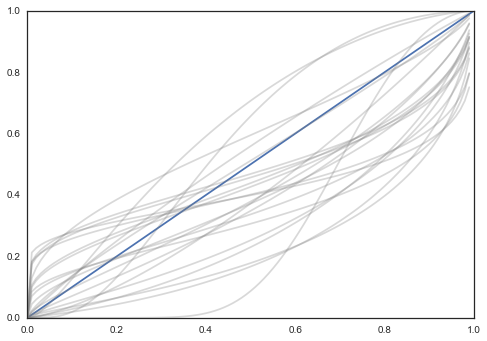

In [165]:
ps = np.arange(0, 1, .01)
plt.plot([0, 1], [0, 1])

for i, row in p2.iterrows():
    plt.plot(ps,prelec(ps, row['prelec_elevation'], row['prelec_gamma']), color='gray', alpha=.3)

## Planned stopping

In [72]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 50],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 20., 1.],
        'w_loss': [0., np.inf, 1.],
        'mu': [0., np.inf, 40.],
        'sc': [0., np.inf, 1.],
        'p_stop': [0, 1, .5]}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,
         'theta': 30}

N_ITER = 3
OUTDIR = 'chase_fitresults_glockner2016'

# a list of different parameter combinations that will
# be fit
PARSETS_GEOM = [#['p_stop', 'p_stay', 'tau'],
                ['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                #['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                ['p_stop', 'p_stay', 'tau', 'pow_gain'],
                #['p_stop', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
               ]

PARSETS_NORMAL = [['mu', 'sc', 'p_stay', 'tau'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma'],
                  ['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                  ['mu', 'sc', 'p_stay', 'tau', 'pow_gain'],
                  #['mu', 'sc', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                  ]

In [15]:
data_exp1.subject.unique()

array([1003, 1006, 1012, 1025, 1026, 1027, 1028, 1029, 1031, 1032, 1033,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1045, 1046, 1050])

In [73]:
for sid in data_exp1.subject.unique()[10:]:

    SIM_ID = 'glockner2016_individual_planned_subj=%s' % sid

    for parset in PARSETS_NORMAL:

        fitting = {p: PARS[p] for p in parset}
        fitting['mu'][2] = data_exp1[data_exp1.subject==sid].samplesize.mean()
        
        # initialize the model
        m = CHASEAlternateStoppingModel(drift='cpt',
                                        startdist='laplace',
                                        stoprule='truncatednormal',
                                        problems=problems)

        # fit
        results = fit_mlh(m, problems, data_exp1[data_exp1.subject==sid], 
                          SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR,
                          method='Powell')

        print results.sort('nllh').head(1)

glockner2016_individual_planned_subj=1033(mu,p_stay,sc,tau|c=0.5,theta=30)
0/3
[]: []
iteration              0
success             True
nllh             247.879
k                      4
N                     58
bic             511.9998
theta                 30
mu               27.1157
p_stay         0.6918667
sc              9.657991
tau          0.000132591
Name: 0, dtype: object
glockner2016_individual_planned_subj=1033(mu,p_stay,sc,tau|c=0.5,theta=30)
1/3
[]: []
iteration              1
success             True
nllh             247.879
k                      4
N                     58
bic             511.9998
theta                 30
mu               27.1157
p_stay         0.6918667
sc              9.657991
tau          0.000132591
Name: 1, dtype: object
glockner2016_individual_planned_subj=1033(mu,p_stay,sc,tau|c=0.5,theta=30)
2/3
[]: []
iteration              2
success             True
nllh             247.879
k                      4
N                     58
bic             511.9

## Comparison

In [74]:
for sid in data_exp1.subject.unique():

    results = pd.DataFrame([], columns=['sim_id', 'stoprule', 'weighting', 'switching',
                                        'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                        'theta', 'p_stop', 'mu', 'sc', 
                                        'prelec_gamma', 'prelec_elevation',
                                        'pow_gain', 'w_loss'])

    for i, parset in enumerate(PARSETS):
        model_id = 'glockner2016_individual_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        FIXED = {'c': 0.5}
        try:
            b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
            results.loc[results.shape[0]] = b
            results.loc[results.shape[0]-1,'stoprule'] = 'optional'
            results.loc[results.shape[0]-1,'switching'] = False
        except:
            print 'nothing for', model_id, fitting
            
    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'glockner2016_individual_planned_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        FIXED = {'c': 0.5,
         'theta': 30}
        b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
        results.loc[results.shape[0]] = b
        results.loc[results.shape[0]-1,'stoprule'] = 'normal'
        results.loc[results.shape[0]-1,'switching'] = False

    results.sort('bic', inplace=True)
    results.to_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid)

In [77]:
compdf = pd.DataFrame([], columns=['sid', 'cond', 'sim_id', 'stoprule', 'weighting', 
                                      'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                      'theta', 'p_stop', 'mu', 'sc', 
                                      'prelec_gamma', 'prelec_elevation',
                                      'pow_gain', 'w_loss'])
for sid in data_exp1.subject.unique():
    tab = model_table(sid, force=True)
    #tab = tab[tab.weighting!='none']
    compdf.loc[compdf.shape[0]] = tab.iloc[0]
    compdf.loc[compdf.shape[0]-1,'sid'] = sid

In [78]:
compdf

,sid,cond,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss
0,1003,NaN,"glockner2016_individual_planned_subj=1003(mu,p...",normal,NaN,6,59,251.599479,527.664183,8.760455e-01,7.730851e-06,30,NaN,30.587491,11.282417,4.263063e-12,3.000012,NaN,NaN
1,1006,NaN,"glockner2016_individual_planned_subj=1006(mu,p...",normal,NaN,6,59,269.565859,563.596942,9.338239e-06,4.389876e-12,30,NaN,41.163935,17.666847,2.669198e-01,1.790046,NaN,NaN
2,1012,NaN,"glockner2016_individual_planned_subj=1012(mu,p...",normal,NaN,6,59,253.894120,532.253465,5.447108e-04,1.393369e-11,30,NaN,33.274612,12.453981,5.446280e-01,1.888954,NaN,NaN
3,1025,NaN,"glockner2016_individual_subj=1025(p_stay,pow_g...",optional,NaN,4,59,245.830636,507.971421,2.153806e-02,2.009504e-06,6,NaN,NaN,NaN,NaN,NaN,0.000199,NaN
4,1026,NaN,"glockner2016_individual_subj=1026(p_stay,prele...",optional,NaN,4,44,133.540575,282.217909,3.757020e-01,1.795345e-10,2,NaN,NaN,NaN,1.880123e+00,NaN,NaN,NaN
5,1027,NaN,"glockner2016_individual_subj=1027(p_stay,pow_g...",optional,NaN,4,58,241.574740,499.391253,5.720414e-04,1.353406e-01,8,NaN,NaN,NaN,NaN,NaN,0.000018,NaN
6,1028,NaN,"glockner2016_individual_subj=1028(p_stay,prele...",optional,NaN,5,59,258.668242,537.724171,1.714284e-02,3.875138e-02,8,NaN,NaN,NaN,6.593758e-01,1.719306,NaN,NaN
7,1029,NaN,"glockner2016_individual_planned_subj=1029(mu,p...",normal,NaN,5,59,276.942565,574.272816,8.432172e-07,2.849721e-07,30,NaN,40.187766,20.305344,4.274778e-01,NaN,NaN,NaN
8,1031,NaN,"glockner2016_individual_planned_subj=1031(mu,p...",normal,NaN,6,59,227.143608,478.752441,1.489691e-03,3.916703e-12,30,NaN,22.816562,9.102241,4.224989e-01,3.126533,NaN,NaN
9,1032,NaN,"glockner2016_individual_planned_subj=1032(mu,p...",normal,NaN,5,59,258.055532,536.498750,4.392726e-01,3.593950e-08,30,NaN,29.333202,11.785539,NaN,NaN,0.219921,NaN


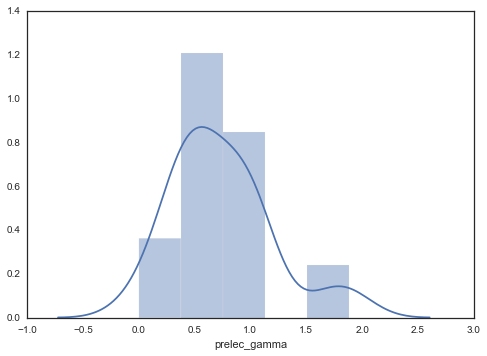

In [167]:
sns.distplot(compdf[~np.isnan(compdf.prelec_gamma)].prelec_gamma)

In [162]:
gamma = compdf.prelec_gamma
gamma[np.isnan(gamma)] = 1
delta = compdf.prelec_elevation
delta[np.isnan(delta)] = 1

ps = np.arange(0, 1, .01)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0, 1], [0, 1])

ax.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=1.3)
for i, row in compdf.iterrows():
    if ~np.isnan(row['mu']):
        if np.isnan(row['prelec_elevation']):
            ax.plot(ps,prelec(ps, 1, row['prelec_gamma']), color='gray', alpha=.3)
        else:
            ax.plot(ps,prelec(ps, row['prelec_elevation'], row['prelec_gamma']), color='gray', alpha=.3)

ax.plot(ps, prelec(ps, delta.mean(), gamma.mean()), color='blue')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.show()

/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Fit CPT (objective probabilities)

In [117]:
cpt_fits = {}

In [127]:
cols = ['subject', 'problem', 'group', 'choice', 'samplesize']
N_FIT_ITER = 1
fixed = {}
fitting = {'s': [0, np.inf, 1.],
           'prelec_gamma': [0, 10, 1.],
           'prelec_elevation': [0, 10, 1.]}

for sid in data_exp1.subject.unique()[:3]:
    d = data_exp1[data_exp1.subject==sid][cols]
    cpt_fits[sid] = cpt.fit(problems, d, 'glockner2016_cptfit', fixed=fixed, fitting=fitting, niter=N_FIT_ITER)
    print cpt_fits[sid]

glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  59  NaN  22.352117          1.373536      0.439934   

         s  
0  0.99264  
glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  59  NaN  16.625862          1.671926      0.300023   

         s  
0  1.26413  
glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  59  NaN  19.810451          1.712544      0.519404   

          s  
0  1.167413  


In [153]:
np.mean([cpt_fits[sid]['prelec_elevation'].values[0] for sid in data_exp1.subject.unique()])
np.mean([cpt_fits[sid]['prelec_gamma'].values[0] for sid in data_exp1.subject.unique()])

1.5682869136244248

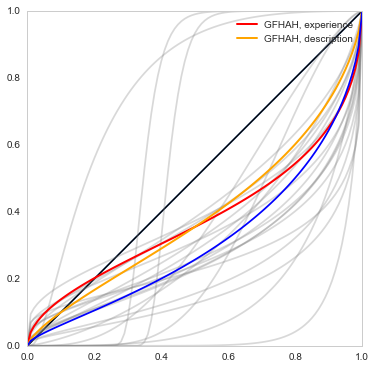

In [242]:
ps = np.arange(0, 1.01, .01)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0, 1], [0, 1])

ax.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=1.3)


for sid in data_exp1.subject.unique():
    ax.plot(ps,prelec(ps, 
                       cpt_fits[sid]['prelec_elevation'].values[0], 
                       cpt_fits[sid]['prelec_gamma'].values[0]), color='gray', alpha=.3)

# reference from Glockner et al 2016
ax.plot(ps, gw(ps, .55, .56), color='red', linewidth=2, label='GFHAH, experience') 
ax.plot(ps, gw(ps, .55, .73), color='orange', linewidth=2, label='GFHAH, description') 

ax.plot(ps, prelec(ps,
                   np.median([cpt_fits[sid]['prelec_elevation'].values[0] for sid in data_exp1.subject.unique()]),
                   np.median([cpt_fits[sid]['prelec_gamma'].values[0] for sid in data_exp1.subject.unique()]))
        , color='blue')

ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.grid(False)
plt.show()


## Fit CPT (experienced probabilities)

In [170]:
def problem_array_exp(row):
    return np.array([[row[['r_aout1', 'r_aprob1']].values, row[['r_aout2', 'r_aprob2']].values],
                     [row[['r_bout1', 'r_bprob1']].values, row[['r_bout2', 'r_bprob2']].values]])

In [197]:
problems_exp = {}

In [198]:
for i, row in data_exp1.iterrows():
    a = problem_array_exp(row)
    
    # check that probabilities sum to one
    for j in range(len(a)):
        a[j][:,1] = a[j][:,1]/a[j][:,1].sum()
    
    problems_exp[i] = a

In [126]:
cpt_fits_exp = {}

In [206]:
for sid in data_exp1.subject.unique()[10:]:
    d = data_exp1[data_exp1.subject==sid][cols]
    cpt_fits_exp[sid] = cpt.fit(problems_exp, d, 'glockner2016_cptfit', fixed=fixed, fitting=fitting, niter=N_FIT_ITER)

glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  58  NaN  12.945205           3.66255      1.544948   

          s  
0  1.016372  
glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  59  NaN  28.414353          4.400598      0.787172   

         s  
0  0.39412  
glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  59  NaN  18.570526          1.650801      0.396306   

          s  
0  1.236632  
glockner2016_cptfit(prelec_elevation,prelec_gamma,s|)
   iteration success  k   N  msd        llh  prelec_elevation  prelec_gamma  \
0          0    True  3  59  NaN  25.432856                10      0.765665   

          s  
0  0.484807  
glockner2016_cptfit(prelec_elevation,p

In [211]:
sns.set_style('whitegrid')

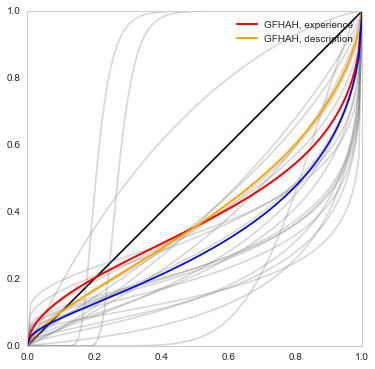

In [244]:
ps = np.arange(0, 1.01, .01)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0, 1], [0, 1])

ax.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=1.3)


for sid in data_exp1.subject.unique():
    ax.plot(ps,prelec(ps, 
                       cpt_fits_exp[sid]['prelec_elevation'].values[0], 
                       cpt_fits_exp[sid]['prelec_gamma'].values[0]), color='gray', alpha=.3)

# reference from Glockner et al 2016
ax.plot(ps, gw(ps, .55, .56), color='red', linewidth=2, label='GFHAH, experience') 
ax.plot(ps, gw(ps, .55, .73), color='orange', linewidth=2, label='GFHAH, description') 

ax.plot(ps, prelec(ps,
                   np.median([cpt_fits_exp[sid]['prelec_elevation'].values[0] for sid in data_exp1.subject.unique()]),
                   np.median([cpt_fits_exp[sid]['prelec_gamma'].values[0] for sid in data_exp1.subject.unique()]))
        , color='blue')

ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.grid(False)
plt.show()

In [255]:
arr = []
for pid in problems_exp:
    prob = problems_exp[pid][0]
    arr.append(prob[prob[:,0].argmax(),1])
    
    prob = problems_exp[pid][1]
    arr.append(prob[prob[:,0].argmax(),1])

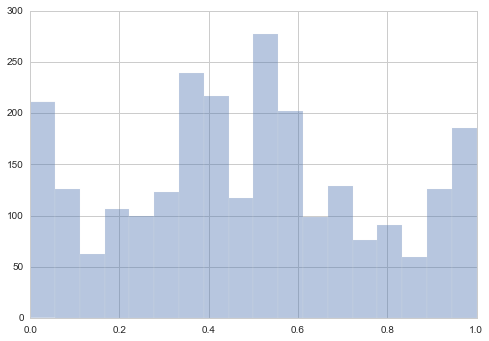

In [259]:
sns.distplot(arr, kde=False)

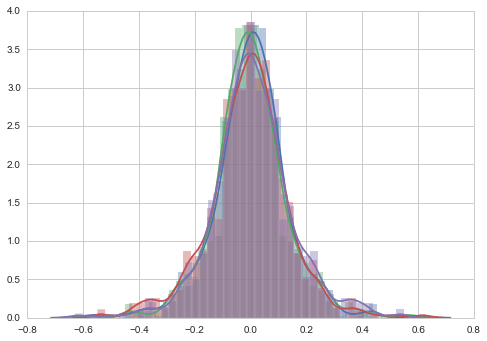

In [222]:

sns.distplot((data_exp1['g1p1'] - data_exp1['r_aprob1']))
sns.distplot((data_exp1['g1p2'] - data_exp1['r_aprob2']))
sns.distplot((data_exp1['g2p1'] - data_exp1['r_bprob1']))
sns.distplot((data_exp1['g2p2'] - data_exp1['r_bprob2']))

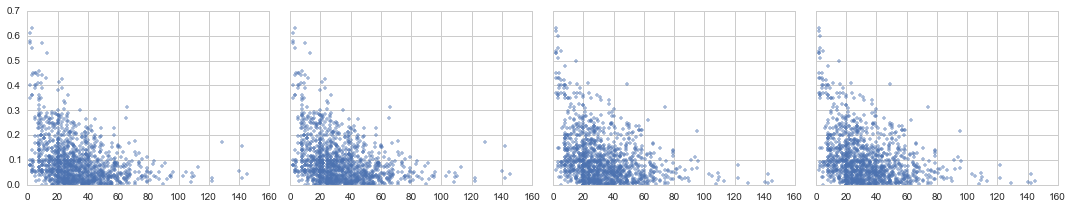

In [240]:
fig, ax = plt.subplots(1, 4, figsize=(15,3), sharey=True)

al = .5

axi = ax[0]
axi.plot(data_exp1['samplesize'].values,
         np.abs((data_exp1['g1p1'] - data_exp1['r_aprob1']).values), '.', alpha=al)

axi = ax[1]
axi.plot(data_exp1['samplesize'].values,
         np.abs((data_exp1['g1p2'] - data_exp1['r_aprob2']).values), '.', alpha=al)

axi = ax[2]
axi.plot(data_exp1['samplesize'].values,
         np.abs((data_exp1['g2p1'] - data_exp1['r_bprob1']).values), '.', alpha=al)

axi = ax[3]
axi.plot(data_exp1['samplesize'].values,
         np.abs((data_exp1['g2p2'] - data_exp1['r_bprob2']).values), '.', alpha=al)

plt.tight_layout()
plt.show()

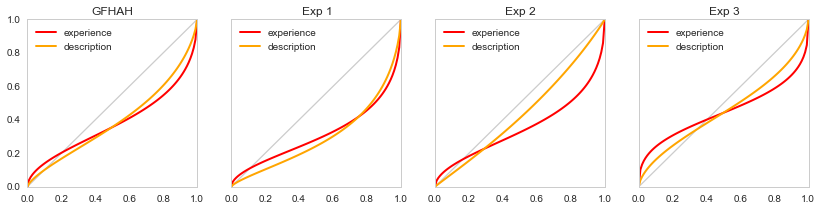

In [272]:
ps = np.arange(0, 1.01, .01)
fig, axi = plt.subplots(1, 4, figsize=(14,3), sharey=True)

for ax in axi:
    ax.plot([0, 1], [0, 1], color='black', alpha=.2, linewidth=1.3)

ax = axi[0]
ax.plot(ps, gw(ps, .553, .561), color='red', linewidth=2, label='experience') 
ax.plot(ps, gw(ps, .555, .732), color='orange', linewidth=2, label='description') 
ax.set_title('GFHAH')

ax = axi[1]
ax.plot(ps, gw(ps, .392, .552), color='red', linewidth=2, label='experience') 
ax.plot(ps, gw(ps, .32,  .735), color='orange', linewidth=2, label='description') 
ax.set_title('Exp 1')

ax = axi[2]
ax.plot(ps, gw(ps, .482, .553), color='red', linewidth=2, label='experience') 
ax.plot(ps, gw(ps, .695, .961), color='orange', linewidth=2, label='description') 
ax.set_title('Exp 2')

ax = axi[3]
ax.plot(ps, gw(ps, .794, .422), color='red', linewidth=2, label='experience') 
ax.plot(ps, gw(ps, .796, .647), color='orange', linewidth=2, label='description') 
ax.set_title('Exp 3')

for ax in axi:
    ax.legend(loc='upper left')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.grid(False)
plt.show()

# Experiment 3

In [4]:
data_exp3 = data[(data.description==0) & (data.exp==4)]
data_exp3.loc[:,'problem'] = np.nan
data_exp3.rename(columns={'subj': 'subject', 'dec': 'choice', 'samples': 'samplesize'}, inplace=True)
data_exp3['choice'] = data_exp3['choice'] - 1
data_exp3['group'] = 0

/Users/markant/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/markant/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/markant/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.or

In [5]:
problems = {}

p = []
for i, row in data_exp3.iterrows():
    a = problem_array(row)
    problems[i] = a
    p.append(i)
data_exp3.loc[:,'problem'] = p

In [29]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'w') as f:
    pickle.dump(problems, f)

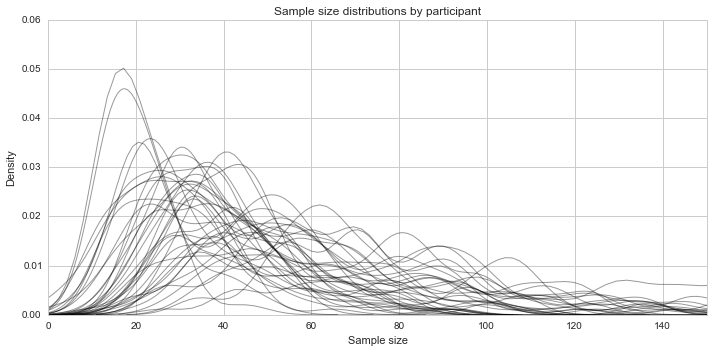

In [277]:
fig, axi = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

ax = axi
for i, grp in data_exp3.groupby('subject'):
    sns.kdeplot(grp.samplesize, bw=5, color='black', alpha=.4, ax=ax, linewidth=1)
ax.legend([])
ax.set_title('Sample size distributions by participant')
ax.set_xlim(0, 150)
ax.set_xlabel('Sample size')
ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

fig.savefig(FIGDEST+'glockner_exp3_samplesize_by_participant.pdf', bbox_inches='tight')

### Optional stopping

In [10]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 10],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'prelec_gamma_loss': [0, 5, 1.],
        'prelec_elevation_loss': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],
        'mu': [0., np.inf, 40.],
        'sc': [0., np.inf, 1.],

}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,
         'dt': .1}

N_ITER = 1
SIM_ID = 'glockner2016'
OUTDIR = 'chase_fitresults_glockner2016'

# a list of different parameter combinations that will
# be fit
PARSETS = [#['theta', 'p_stay', 'tau'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma'],
           #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation', 'pow_gain'],
           #['theta', 'p_stay', 'tau', 'pow_gain'],
           ]

In [291]:
for sid in data_exp3.subject.unique()[10:]:
    
    SIM_ID = 'glockner2016_individual_subj=%s' % sid

    for parset in PARSETS:

        fitting = {p: PARS[p] for p in parset}

        # initialize the model
        m = CHASEModel(drift='cpt',
                       startdist='laplace',
                       problems=problems)

        # fit
        results = fit_mlh(m, problems, data_exp3[data_exp3.subject==sid], 
                          SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

        print results.sort('nllh')

glockner2016_individual_subj=4114(p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta|c=0.5)
0/10
['theta']: [ 1.]
iteration                      0
success                     True
nllh                    355.4206
k                              6
N                             69
bic                     736.2458
theta                          1
p_stay                 0.9726498
pow_gain               0.8433503
prelec_elevation         1.67007
prelec_gamma           0.3259405
tau                 1.613372e-08
Name: 0, dtype: object
glockner2016_individual_subj=4114(p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta|c=0.5)
1/10
['theta']: [ 2.]
iteration                      0
success                     True
nllh                    347.2723
k                              6
N                             69
bic                     719.9493
theta                          2
p_stay                 0.9090347
pow_gain               0.5009217
prelec_elevation        1.132436
prelec_gamma 

### Planned stopping

In [5]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [1, 50],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 20., 1.],
        'w_loss': [0., np.inf, 1.],
        'mu': [0., np.inf, 40.],
        'sc': [0., np.inf, 1.],
        'p_stop': [0, 1, .5]}

# parameters that are set to fixed values 
FIXED = {'c': 0.5,
         'theta': 30}

N_ITER = 1
OUTDIR = 'chase_fitresults_glockner2016'

PARSETS_NORMAL = [['mu', 'sc', 'p_stay', 'tau'],
                  #['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma'],
                  #['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                  #['mu', 'sc', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation', 'pow_gain'],
                  #['mu', 'sc', 'p_stay', 'tau', 'pow_gain'],
                  #['mu', 'sc', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                  ]

In [6]:
for sid in data_exp3.subject.unique():

    SIM_ID = 'glockner2016_individual_planned_subj=%s' % sid

    for parset in PARSETS_NORMAL:

        fitting = {p: PARS[p] for p in parset}
        fitting['mu'][2] = data_exp3[data_exp3.subject==sid].samplesize.mean()
        
        # initialize the model
        m = CHASEAlternateStoppingModel(drift='cpt',
                                        startdist='laplace',
                                        stoprule='truncatednormal',
                                        problems=problems)

        # fit
        results = fit_mlh(m, problems, data_exp3[data_exp3.subject==sid], 
                          SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR,
                          method='Powell')

        print results.sort('nllh').head(1)

glockner2016_individual_planned_subj=4053(mu,p_stay,sc,tau|c=0.5,theta=30)
0/1
[]: []
iteration            0
success           True
nllh          320.4043
k                    4
N                   69
bic           657.7451
theta               30
mu            43.20469
p_stay       0.8426389
sc            14.03059
tau          0.3125517
Name: 0, dtype: object
   iteration success        nllh  k   N         bic  theta         mu  \
0          0    True  320.404328  4  69  657.745082     30  43.204695   

     p_stay         sc       tau  
0  0.842639  14.030588  0.312552  
glockner2016_individual_planned_subj=4056(mu,p_stay,sc,tau|c=0.5,theta=30)
0/1
[]: []
iteration            0
success           True
nllh          358.1644
k                    4
N                   69
bic           733.2652
theta               30
mu             61.4672
p_stay       0.9389506
sc            23.35019
tau          0.4964287
Name: 0, dtype: object
   iteration success        nllh  k   N         bic  theta 

IndexError: index 302 is out of bounds for axis 0 with size 299

### Comparison

In [297]:
data_exp3.subject.unique()

array([4053, 4056, 4059, 4060, 4086, 4089, 4095, 4088, 4117, 4116, 4114,
       4110, 4099, 4111, 4112, 4135, 4139, 4129, 4055, 4050, 4051, 4057,
       4058, 4061, 4085, 4087, 4091, 4092, 4094, 4090, 4118, 4115, 4113,
       4098, 4109, 4140, 4141, 4142])

In [14]:
for sid in data_exp3.subject.unique():
    
    results = pd.DataFrame([], columns=['sim_id', 'stoprule', 'weighting', 'switching',
                                        'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                        'theta', 'p_stop', 'mu', 'sc', 
                                        'prelec_gamma', 'prelec_elevation',
                                        'pow_gain', 'w_loss'])

    for i, parset in enumerate(PARSETS):
        model_id = 'glockner2016_individual_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        FIXED = {'c': 0.5}
        try:
            b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
            results.loc[results.shape[0]] = b
            results.loc[results.shape[0]-1,'stoprule'] = 'optional'
            results.loc[results.shape[0]-1,'switching'] = False
        except:
            print 'nothing for', model_id, fitting
            
    for i, parset in enumerate(PARSETS_NORMAL):
        model_id = 'glockner2016_individual_planned_subj=%s' % sid
        fitting = {p: PARS[p] for p in parset}
        FIXED = {'c': 0.5,
         'theta': 30}
        try:
            b = best_result(model_id, FIXED, fitting, outdir=OUTDIR)
            results.loc[results.shape[0]] = b
            results.loc[results.shape[0]-1,'stoprule'] = 'normal'
            results.loc[results.shape[0]-1,'switching'] = False
        except:
            print 'nothing for', model_id, fitting


    results.sort('bic', inplace=True)
    results.to_csv(OUTDIR+'/modelcomparison_subj=%s.csv' % sid)

nothing for glockner2016_individual_planned_subj=4050 {'tau': [0, 1, 0.5], 'pow_gain': [0.0, 20.0, 1.0], 'mu': [0.0, inf, 28.043478260869566], 'prelec_elevation': [0, 5, 1.0], 'sc': [0.0, inf, 1.0], 'p_stay': [0, 1, 0.5], 'prelec_gamma': [0, 5, 1.0]}


In [17]:
compdf = pd.DataFrame([], columns=['sid', 'cond', 'sim_id', 'stoprule', 'weighting', 
                                      'k', 'N', 'nllh', 'bic', 'p_stay', 'tau', 
                                      'theta', 'p_stop', 'mu', 'sc', 
                                      'prelec_gamma', 'prelec_elevation',
                                      'pow_gain', 'w_loss'])
for sid in data_exp3.subject.unique():
    tab = model_table(sid, force=True)
    #tab = tab[tab.weighting!='none']
    compdf.loc[compdf.shape[0]] = tab.iloc[0]
    compdf.loc[compdf.shape[0]-1,'sid'] = sid

In [18]:
compdf

,sid,cond,sim_id,stoprule,weighting,k,N,nllh,bic,p_stay,tau,theta,p_stop,mu,sc,prelec_gamma,prelec_elevation,pow_gain,w_loss
0,4053,NaN,"glockner2016_individual_planned_subj=4053(mu,p...",normal,NaN,7,69,319.614849,668.868444,8.411816e-01,5.235766e-06,30,NaN,43.204695,14.030586,1.138082,0.947870,0.504192,NaN
1,4056,NaN,"glockner2016_individual_planned_subj=4056(mu,p...",normal,NaN,7,69,351.462971,732.564688,7.214879e-01,1.712557e-01,30,NaN,61.468242,23.350132,1.068254,0.393271,0.000099,NaN
2,4059,NaN,"glockner2016_individual_planned_subj=4059(mu,p...",normal,NaN,7,69,313.043386,655.725517,6.347084e-01,3.761148e-10,30,NaN,34.809558,12.778614,0.703338,0.528582,0.119332,NaN
3,4060,NaN,"glockner2016_individual_planned_subj=4060(mu,p...",normal,NaN,7,69,290.174474,609.987693,3.825513e-01,2.956189e-01,30,NaN,21.015284,9.785170,0.831932,0.657362,0.638574,NaN
4,4086,NaN,"glockner2016_individual_planned_subj=4086(mu,p...",normal,NaN,7,69,361.186592,752.011931,9.174063e-01,2.433409e-05,30,NaN,64.524310,30.579200,0.775620,1.893668,0.103148,NaN
5,4089,NaN,"glockner2016_individual_planned_subj=4089(mu,p...",normal,NaN,7,69,297.882424,625.403594,6.503514e-01,6.598310e-12,30,NaN,33.646699,10.590836,1.549823,0.327798,0.198496,NaN
6,4095,NaN,"glockner2016_individual_planned_subj=4095(mu,p...",normal,NaN,7,69,331.495451,692.629647,9.326370e-01,3.226679e-01,30,NaN,48.960729,19.625805,0.185446,3.238407,1.067984,NaN
7,4088,NaN,"glockner2016_individual_planned_subj=4088(mu,p...",normal,NaN,7,68,335.469543,700.475641,9.331881e-01,5.439116e-12,30,NaN,31.322665,22.960230,2.771693,1.069957,0.192824,NaN
8,4117,NaN,"glockner2016_individual_planned_subj=4117(mu,p...",normal,NaN,7,69,361.679535,752.997815,4.134555e-01,4.655775e-09,30,NaN,49.463436,32.982758,0.504359,0.648154,0.442348,NaN
9,4116,NaN,"glockner2016_individual_planned_subj=4116(mu,p...",normal,NaN,7,69,372.077170,773.793086,3.159814e-01,1.881482e-11,30,NaN,66.063330,37.725682,0.407764,0.454739,0.398572,NaN


/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/markant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


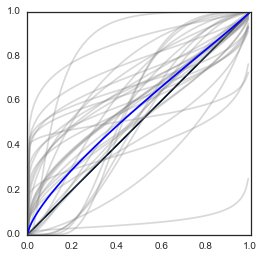

In [22]:
gamma = compdf.prelec_gamma
gamma[np.isnan(gamma)] = 1
delta = compdf.prelec_elevation
delta[np.isnan(delta)] = 1

ps = np.arange(0, 1, .01)
fig, ax = plt.subplots(figsize=(4,4))
ax.plot([0, 1], [0, 1])

ax.plot([0, 1], [0, 1], color='black', alpha=1, linewidth=1.3)
for i, row in compdf.iterrows():
    if ~np.isnan(row['mu']):
        if np.isnan(row['prelec_elevation']):
            ax.plot(ps,prelec(ps, 1, row['prelec_gamma']), color='gray', alpha=.3)
        else:
            ax.plot(ps,prelec(ps, row['prelec_elevation'], row['prelec_gamma']), color='gray', alpha=.3)

ax.plot(ps, prelec(ps, delta.mean(), gamma.mean()), color='blue')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
plt.show()